# **Table of contents**


1.   Import Libraries
     *   load data

2.   EDA on Tags features

  *   checking the top tags
  *   tags per question

3.   Topic assignment: Supervised Methods 

   *   Loading and generating Multi-label datasets
       *  Filtering top 100 main_tags
       *  Generating Multi-label Datasets
   *   Problem transformation Method
       * Binary relevance
       * Classifer chain
       * Label Powerset

   *   OneVsRest Classifeir

   *   Adapted Algorithm
       * Multi knn classifier
       * Tuning hyper-parameters for multikNN model
   *   Final model

      * Test on unseen document

## **Import Libraries**

In [1]:
pip install scikit-multilearn

     |████████████████████████████████| 92kB 3.7MB/s 


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import nltk
from sklearn.multiclass import OneVsRestClassifier
from nltk.tokenize import word_tokenize
from skmultilearn.adapt import MLkNN
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from skmultilearn.problem_transform import LabelPowerset,ClassifierChain,BinaryRelevance
from sklearn.metrics import accuracy_score,hamming_loss
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer,TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import make_pipeline,Pipeline
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
nltk.download('punkt')
%matplotlib inline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


### Load the data

In [3]:
data=pd.read_csv('/content/drive/MyDrive/Formation_Machine_Learning/P_NLP/data/data.csv')

In [4]:
data.dropna(inplace=True)

In [114]:
data_nouns=pd.read_csv('/content/drive/MyDrive/Formation_Machine_Learning/P_NLP/data/data_nouns.csv')

In [ ]:
data_nouns.dropna(inplace=True)

In [5]:
data

,Title,Body,Code,Tags
0,export default import vue find vue,beginner vuejs first app save nothing appear b...,import bootstrapvue from bootstrap vue i...,vuejs
1,iterate two list parallel kotlin,iterate two list kotlin assign value one list ...,textviewdata class total val area double pr...,list kotlin
2,directory contain directory,currently exclude directory contain sub direct...,find type a sub b sub sub dub sub bub fin...,bash find
3,faster element roll permutation swap two list,two list like take combination two list place ...,x a c original lists y b a c we...,python list algorithm
4,wait open txt file notepad cplusplus,open txt file notepad continue close notepad c...,string string topicname c hello hi hi txt ...,cplusplus windows
...,...,...,...,...
9995,swiftui state sheet VisualStudio,hello run problem consistent behavior sheet vi...,state private var label string quot quot...,swiftui
9996,update google ads sdk onadfailedtoload depreca...,update google ads sdk give deprecated warning ...,onadfailedtoload public void banneradmob ...,android admob banner ads
9997,entry res color material_on_surface_disabled x...,create sign apk add two file project my_web_ac...,lt xml version encoding utf gt lt ...,android studio layout kotlin webview
9998,csharp perform short circuit evaluation statem...,believe csharp stop evaluate statement conditi...,if lt amp amp check_something_else ...,csharp if statement async await short circuiting


## **Exploratory Data Analysis of Tags feature**

### checking the top tags 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


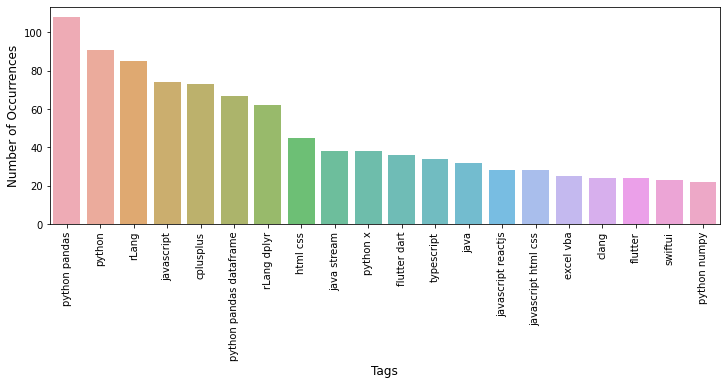

In [ ]:
count_tags=data['Tags'].value_counts().head(20)
plt.figure(figsize=(12,4))
sns.barplot(count_tags.index, count_tags.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Tags', fontsize=12)
plt.xticks(rotation=90)
plt.show()

it seems like our users most recent researchs are dedicated to datascience with python and pandas.

Lets check the rest of the top tags: 

- python pandas 
- R language
- Javascripts 
- C++

### Counting the number of tags associated with each question.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


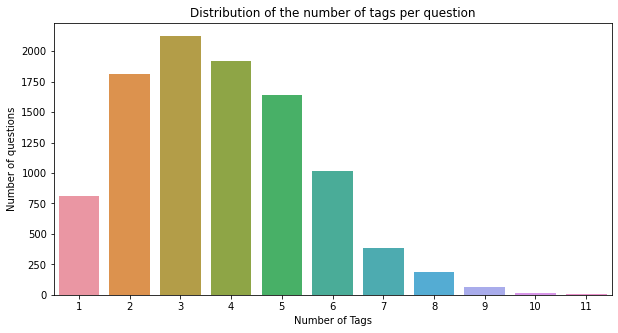

In [ ]:
# We are going to add new feature corresponding of counting tags
data['Tags_count']=data['Tags'].apply(lambda x: len(str(x).split(' ')))
tag_length=data['Tags_count'].value_counts()
plt.figure(figsize=(10,5))
#sns.countplot(df_no_dup.tag_count, palette='gist_rainbow')
sns.barplot(tag_length.index,tag_length.values)
plt.title("Distribution of the number of tags per question")
plt.xlabel("Number of Tags")
plt.ylabel("Number of questions")
plt.show()

- This shows that we have a normal distribution of our tags with the questions asked.

- most of the requests were given between 2 and 4 tags 

- we have some outliers like 10 and 11 tags which seems a bit extreme

# **Topic assignment: Supervised Methods**

## **Loading and Generating Multi-Label Datasets**


### Filtering top100  **main_tags**

In [7]:
def top_tags(df,max_tags):

  #BOW from the tags
  tag_vect=CountVectorizer()
  vectorized_tags=tag_vect.fit_transform(df['Tags'])

  #filter the top 100 tags according to occurences 
  tags_count=np.sum(vectorized_tags.toarray(),axis=0)
  sorted_tags=np.argsort(-tags_count)
  top_tags_index=sorted_tags[:max_tags]

  tags_dict={'tag':[],
             'tag_occurences':[]}

  for i in top_tags_index:
    tags_dict['tag'].append(tag_vect.get_feature_names()[i])
    tags_dict['tag_occurences'].append(tags_count[i])

  return pd.DataFrame(tags_dict)

This function help us identify the occurence of each tag along all the tags provided. 

In order to be sufficient, we are going to filter the tags and take into consideration the top 100 tags 

In [8]:
top_tag_dt=top_tags(data,100)
top_tag_dt.head(10)

,tag,tag_occurences
0,python,1876
1,javascript,1023
2,java,782
3,rlang,694
4,cplusplus,625
5,android,530
6,reactjs,486
7,pandas,448
8,js,360
9,html,338


- As it was expected,we got **Python**, **Javascript**, **C++** as our top tags 

- Next we are going to keep **tags list** which contains only tags from the **top_tag** dataframe, in order to focus on the main tags 

### **Generating Multi-Label Datasets**

In order to generate the Multi-label dataset we need to: 

- keep only questions which contains the tags from the previous selection of tags 

- perform a onehot encoding to the multi-labels 

- and then merge the two dataframes

In [9]:
def MultiLabel_data(df):

  #create main_tags from the top_tag data

  df['main_tags']=df['Tags'].apply(lambda x: ' '.join(word for word in word_tokenize(x) if word in top_tag_dt['tag'].values.tolist()))
  df.loc[df['main_tags']=='','main_tags']=np.nan
  df.dropna(inplace=True)

  #encode the tags

  tags_vect=CountVectorizer()
  tags_values=tags_vect.fit_transform(df['main_tags'])
  encoded_tags=pd.DataFrame(tags_values.toarray(),columns=tags_vect.get_feature_names(),index=df.index)

  #join data with encoded data in order to get the multi-label dataset

  df=df.join(encoded_tags)
  
  return df

In [10]:
data_labels=MultiLabel_data(data)

In [ ]:
data_labels.sample(3)

,Title,Body,Code,Tags,main_tags,algorithm,amazon,android,angular,apache,api,arrays,asp,aws,azure,bash,boot,clang,cloud,code,compose,core,cplusplus,csharp,css,dart,data,dataframe,django,docker,dplyr,excel,firebase,flutter,for,framework,function,functions,generics,git,...,multithreading,mysql,native,net,next,node,npm,numpy,pandas,performance,php,postgresql,powershell,programming,python,react,reactjs,regex,rlang,ruby,scala,server,services,spark,spring,sql,stream,string,studio,swift,swiftui,templates,tensorflow,tidyverse,typescript,visual,vuejs,web,windows,xcode
1187,express delete work give find error,use boilerplate api use express typeorm typesc...,not foundquestion ts entity export class que...,typescript express typeorm,typescript,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
9274,dbcontext di desktop application,work several non web application always strugg...,entity frameworkgeneric repositorydbcontext pe...,csharp wpf entity framework net core dependenc...,csharp framework net core,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7944,inflate progressbar layout duplication api,flow app declare endpoint retrofit service ins...,public interface endpoints get constants po...,java android mvvm progressbar,java android,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


As we can see here, the dataframe **data_labels** combines the corpus texts along with **main_tags** encoded

Lets check the distribution of our tags, after we have performed the dimentionality reductionn 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


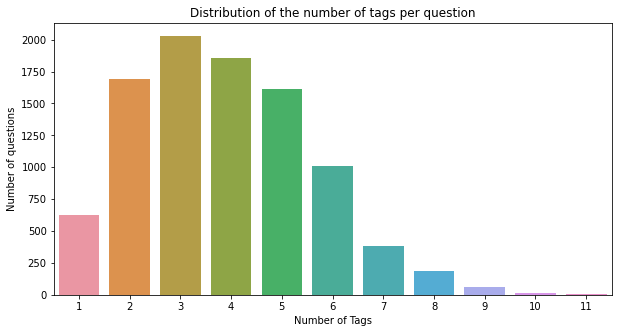

In [ ]:
data_labels['Tags_count']=data_labels['Tags'].apply(lambda x: len(str(x).split(' ')))
tag_length=data_labels['Tags_count'].value_counts()
plt.figure(figsize=(10,5))
sns.barplot(tag_length.index,tag_length.values)
plt.title("Distribution of the number of tags per question")
plt.xlabel("Number of Tags")
plt.ylabel("Number of questions")
plt.show()

- We can see that, although we have taken half of the tags, we did preserve the same distribution of our tags per question 

- Actually we did lose only 35 questions 

In [ ]:
X = data_labels['Title'].values
y = data_labels.iloc[:,5:].values
  
# initializing TfidfVectorizer 
vectorizar = TfidfVectorizer(max_features=3000, max_df=0.85)
# fitting the tf-idf on the given data
vectorizar.fit(X)
  
# splitting the data to training and testing data set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
  
# transforming the data
X_train_tfidf = vectorizar.transform(X_train)
X_test_tfidf = vectorizar.transform(X_test)

In [116]:
print('shape of X_train_tfidf: {}'.format(X_train_tfidf.shape))
print('\n')
print('shape of X_test_tfidf: {}'.format(X_test_tfidf.shape))
print('\n')
print('shape of y_train: {}'.format(y_train.shape))
print('\n')
print('shape of y_test: {}'.format(y_test.shape))

shape of X_train_tfidf: (6399, 3000)


shape of X_test_tfidf: (2743, 3000)


shape of y_train: (6399, 100)


shape of y_test: (2743, 100)


## **Problem transformation Method**

In this section, we are going to deal with the problem transformation methods, the main idea is to convert our multi-label problem into single-label problem.

This method can be carried out in three different ways as:

- **Binary Relevance**

- **Classifier Chains**

- **Label Powerset**

- **OneVsRestClassifier**

### Binary relevance

- This is one of the simplest technique. The idea behind this algorithm, is to treat each single label separatly and consider it as a single class classification problem.

- In **binary relevance**, this problem is broken into N different single class classification problems. the multi-learn library provides this implementation in python.

#### Gaussian NB

In [ ]:
binary_classifier=BinaryRelevance(GaussianNB())

In [ ]:
binary_classifier.fit(X_train_tfidf,y_train)

BinaryRelevance(classifier=GaussianNB(priors=None, var_smoothing=1e-09),
                require_dense=[True, True])

In [ ]:
pred_binary = binary_classifier.predict(X_test_tfidf)

In [ ]:
accuracy_score(y_test,pred_binary)

0.04187192118226601

In [ ]:
hamming_loss(y_test,pred_binary)

0.026372184638887613

#### Logistic Regression

In [ ]:
binary_clf_log=BinaryRelevance(LogisticRegression())
binary_clf_log.fit(X_train_tfidf,y_train)
pred_log = binary_clf_log.predict(X_test_tfidf)

In [ ]:
print(accuracy_score(y_test, pred_log))
print(hamming_loss(y_test, pred_log))

0.0844475721323012
0.01036498467000732


#### Random Forest 

In [117]:
binary_clf_rand=BinaryRelevance(RandomForestClassifier())
binary_clf_rand.fit(X_train_tfidf,y_train)
pred_forest = binary_clf_rand.predict(X_test_tfidf)

BinaryRelevance(classifier=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                                  class_weight=None,
                                                  criterion='gini',
                                                  max_depth=None,
                                                  max_features='auto',
                                                  max_leaf_nodes=None,
                                                  max_samples=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100, n_jobs=None,
                                                  oo

In [ ]:
print(accuracy_score(y_test, pred_forest))
print(hamming_loss(y_test, pred_forest))

0.15517241379310345
0.008948684308240711


#### XGBoost Classifier

In [ ]:
binary_clf_boost=BinaryRelevance(XGBClassifier())
binary_clf_boost.fit(X_train_tfidf,y_train)
pred_boost = binary_clf_boost.predict(X_test_tfidf)
print(accuracy_score(y_test, pred_boost))
print(hamming_loss(y_test, pred_boost))

### Classifier chains

- For this part, the first classifier is trained just on the input data and then each next classifier is trained on the input space and all the previous classifiers 

- In the chain.  This is quite similar to binary relevance, the only difference being it forms chains in order to preserve label correlation

#### Gauussian Naives Bayes



In [ ]:
classifier_chain=ClassifierChain(GaussianNB())

In [ ]:
classifier_chain.fit(X_train_tfidf,y_train)

ClassifierChain(classifier=GaussianNB(priors=None, var_smoothing=1e-09),
                order=None, require_dense=[True, True])

In [ ]:
pred_chain = classifier_chain.predict(X_test_tfidf)

In [ ]:
hamming_loss(y_test,pred_chain)

0.028363897878460984

In [ ]:
accuracy_score(y_test,pred_chain)

0.07047824523552679

#### Logistic Regression

In [ ]:
clf_chain_log=ClassifierChain(LogisticRegression())
clf_chain_log.fit(X_train_tfidf,y_train)
pred_chain_log = clf_chain_log.predict(X_test_tfidf)
hamming_loss(y_test,pred_chain_log)
accuracy_score(y_test,pred_chain_log)


#### Random Forest

In [ ]:
clf_chain_rand=ClassifierChain(RandomForestClassifier())
clf_chain_rand.fit(X_train_tfidf,y_train)
pred_forest_chain = clf_chain_rand.predict(X_test_tfidf)
print(accuracy_score(y_test, pred_forest_chain))
print(hamming_loss(y_test, pred_forest_chain))

#### XGBoost

In [ ]:
clf_chain_boost=ClassifierChain(XGBClassifier())
clf_chain_boost.fit(X_train_tfidf,y_train)
pred_boost_chain = clf_chain_boost.predict(X_test_tfidf)
print(accuracy_score(y_test, pred_boost_chain))
print(hamming_loss(y_test, pred_boost_chain))

###Label Powerset

- In this, we transform the problem into a multi-class problem with one multi-class classifier is trained on all unique label combinations found in the training data.

- So, label powerset has given a unique class to every possible label combination that is present in the training set.

In [ ]:
classifier_label=LabelPowerset(GaussianNB())
classifier_label.fit(X_train_tfidf,y_train)
pred_label = classifier_label.predict(X_test_tfidf)
print(hamming_loss(y_test,pred_label))
print('\n')
print(accuracy_score(y_test,pred_label))

0.023728874505573535


0.14922689679971232


In [ ]:
classifier_label=LabelPowerset(LogisticRegression())
classifier_label.fit(X_train_tfidf,y_train)
pred_label = classifier_label.predict(X_test_tfidf)
print(hamming_loss(y_test,pred_label))
print('\n')
print(accuracy_score(y_test,pred_label))

0.012391302041523593


0.14567206192821958


In [ ]:
clf_label_forest=LabelPowerset(RandomForestClassifier())
clf_label_forest.fit(X_train_tfidf,y_train)
pred_label_forest = clf_label_forest.predict(X_test_tfidf)
print(hamming_loss(y_test,pred_label_forest))
print('\n')
print(accuracy_score(y_test,pred_label_forest))

In [ ]:
clf_label_boost=LabelPowerset(XGBClassifier())
clf_label_boost.fit(X_train_tfidf,y_train)
pred_boost_label = clf_label_boost.predict(X_test_tfidf)
print(accuracy_score(y_test, pred_boost_label))
print(hamming_loss(y_test, pred_boost_label))

0.13230119634060522
0.012912910788990695


## OneVsRestClassifier

- OneVsRestClassifier is similar to the binary relevance Method

- It give us the ability to work with the GridSearch Methods and to optimise parameters via a hyper-parameter tuning

In [ ]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=3000, max_df=0.85,stop_words='english')),
    ('clf', OneVsRestClassifier(LogisticRegression()))])
parameters = {
    "clf__estimator__C": [0.01, 0.1, 1],
    "clf__estimator__penalty":['l1','l2']

}


### Multinomial Naives Bayes

In [ ]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=3000, max_df=0.85,stop_words='english')),
    ('clf', OneVsRestClassifier(MultinomialNB(
        fit_prior=True, class_prior=None))),
])
parameters = {
    'tfidf__max_df': (0.25, 0.5, 0.75),
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'clf__estimator__alpha': (1e-2, 1e-3)
}

In [ ]:
grid_search_tune = GridSearchCV(
    pipeline, parameters, cv=2, n_jobs=2, verbose=3)
grid_search_tune.fit(X_train, y_train)

Fitting 2 folds for each of 18 candidates, totalling 36 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:   18.6s
[Parallel(n_jobs=2)]: Done  36 out of  36 | elapsed:   23.7s finished


GridSearchCV(cv=2, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('tfidf',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=0.85,
                                                        max_features=3000,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        

In [ ]:
print("Best estimator: ",grid_search_tune.best_estimator_)
print("Best Cross Validation Score: ",grid_search_tune.best_score_)

Best estimator:  Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.25, max_features=3000,
                                 min_df=1, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 OneVsRestClassifier(estimator=MultinomialNB(alpha=0.01,
                                                   

### XGBoost

In [ ]:
params = {'estimator__learning_rate' :[0.01, 0.1, 0.2],
          'estimator__n_estimators':[10,100,500],
          'estimator__subsample':(0.2,0.6,0.8),
          'estimator__max_depth':np.arange(1,6),
          'estimator__min_child_weight':np.arange(1,6)}
base_estimator = OneVsRestClassifier(XGBClassifier(), n_jobs=-1)
rsearch_cv = RandomizedSearchCV(estimator=base_estimator, param_distributions=params, n_iter=10, cv=2, scoring='f1_micro', n_jobs=-1, verbose=1)
rsearch_cv.fit(X_train_tfidf, y_train)

Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 13.4min finished


RandomizedSearchCV(cv=2, error_score=nan,
                   estimator=OneVsRestClassifier(estimator=XGBClassifier(base_score=0.5,
                                                                         booster='gbtree',
                                                                         colsample_bylevel=1,
                                                                         colsample_bynode=1,
                                                                         colsample_bytree=1,
                                                                         gamma=0,
                                                                         learning_rate=0.1,
                                                                         max_delta_step=0,
                                                                         max_depth=3,
                                                                         min_child_weight=1,
                                                      

In [118]:
boost_best=OneVsRestClassifier(estimator=XGBClassifier(base_score=0.5,
                                                                         booster='gbtree',
                                                                         colsample_bylevel=1,
                                                                         colsample_bynode=1,
                                                                         colsample_bytree=1,
                                                                         gamma=0,
                                                                         learning_rate=0.1,
                                                                         max_delta_step=0,
                                                                         max_depth=3,
                                                                         min_child_weight=1,
                                                                         missing=None,
                                                                         n_estimators=100,
                                                                         n_jobs=1,
                                                                         nthread=None,
                                                                         objective='binary:logistic',
                                                                         random_state=101))
boost_best.fit(X_train_tfidf, y_train)

OneVsRestClassifier(estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1, gamma=0,
                                            learning_rate=0.1, max_delta_step=0,
                                            max_depth=3, min_child_weight=1,
                                            missing=None, n_estimators=100,
                                            n_jobs=1, nthread=None,
                                            objective='binary:logistic',
                                            random_state=101, reg_alpha=0,
                                            reg_lambda=1, scale_pos_weight=1,
                                            seed=None, silent=None, subsample=1,
                                            verbosity=1),
                    n_jobs=None)

In [ ]:
boost_best=OneVsRestClassifier(estimator=XGBClassifier(base_score=0.5,
                                                                         booster='gbtree',
                                                                         colsample_bylevel=1,
                                                                         colsample_bynode=1,
                                                                         colsample_bytree=1,
                                                                         gamma=0,
                                                                         learning_rate=0.1,
                                                                         max_delta_step=0,
                                                                         max_depth=3,
                                                                         min_child_weight=1,
                                                                         missing=None,
                                                                         n_estimators=100,
                                                                         n_jobs=1,
                                                                         nthread=None,
                                                                         objective='binary:logistic',
                                                                         random_state=101))
boost_best.fit(X_train_tfidf, y_train)
pred_boost_best = boost_best.predict(X_test_tfidf)
print(hamming_loss(y_test,pred_boost_best))
print('\n')
print(accuracy_score(y_test,pred_boost_best))

0.008840826228255988


0.1688951442646024


###Random forest

In [ ]:
params = {'estimator__n_estimators': [10,100,250,500],
          'estimator__min_weight_fraction_leaf': [0,0.25,0.5],
          'estimator__max_depth': np.arange(1,6),
          'estimator__min_samples_leaf': np.arange(0.05,0.5,0.05),
          'estimator__min_samples_split':np.arange(0.05,1.0,0.05)}

In [ ]:
base_estimator=OneVsRestClassifier(RandomForestClassifier(criterion='gini', class_weight='balanced'), n_jobs=-1)
rsearch_cv = RandomizedSearchCV(estimator=base_estimator, param_distributions=params, n_iter=15, cv=5, scoring='f1_micro', n_jobs=-1, verbose=1)
rsearch_cv.fit(X_train_tfidf, y_train)
print("Best estimator: ",rsearch_cv.best_estimator_)
print("Best Cross Validation Score: ",rsearch_cv.best_score_)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 32.3min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 65.6min finished


Best estimator:  OneVsRestClassifier(estimator=RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight='balanced',
                                                     criterion='gini',
                                                     max_depth=5,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=0.25,
                                                     min_samples_split=0.4,
                                                     min_weight_fraction_leaf=0.5,
                   

In [ ]:
boost_best=OneVsRestClassifier(estimator=RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight='balanced',
                                                     criterion='gini',
                                                     max_depth=5,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=0.25,
                                                     min_samples_split=0.4,
                                                     min_weight_fraction_leaf=0.5,
                                                     n_estimators=250,
                                                     n_jobs=None,
                                                     oob_score=False,
                                                     random_state=None,
                                                     verbose=0,
                                                     warm_start=False))
boost_best.fit(X_train_tfidf,y_train)
pred_boost_best = boost_best.predict(X_test_tfidf)
print(hamming_loss(y_test,pred_boost_best))
print('\n')
print(accuracy_score(y_test,pred_boost_best))

0.174959951057186


0.0


### Logistic Regression

In [ ]:
alpha = [0.0001,0.01,0.1,1,10,100]
penalty=['l1','l2']
params  = {"estimator__C":alpha,
           "estimator__penalty":penalty}
base_estimator = OneVsRestClassifier(LogisticRegression())
rand_cv = RandomizedSearchCV(estimator=base_estimator, param_distributions=params,n_iter=10, cv=5, scoring='f1_micro', n_jobs=-1, verbose=1)
rand_cv.fit(X_train_tfidf, y_train)
print("Best estimator: ",rand_cv.best_estimator_)
print("Best Cross Validation Score: ",rand_cv.best_score_)

In [ ]:
boost_best=OneVsRestClassifier(estimator=LogisticRegression(C=100, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False))
boost_best.fit(X_train_tfidf,y_train)
pred_boost_best = boost_best.predict(X_test_tfidf)
print(hamming_loss(y_test,pred_boost_best))
print('\n')
print(accuracy_score(y_test,pred_boost_best))

### kNearestNeighbors Classifier

In [ ]:
leafs = list(range(1,50))
neighbors = list(range(1,30))
p_=[1,2]
#Convert to dictionary
params = {'estimator__leaf_size': leafs,
          'estimator__n_neighbors': neighbors,
          'estimator__p': p_}
base_estimator = OneVsRestClassifier(KNeighborsClassifier())
rand_cv = RandomizedSearchCV(estimator=base_estimator, param_distributions=params,n_iter=15, cv=5, scoring='f1_micro', n_jobs=-1, verbose=1)
rand_cv.fit(X_train_tfidf, y_train)
print("Best estimator: ",rand_cv.best_estimator_)
print("Best Cross Validation Score: ",rand_cv.best_score_)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 30.4min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 50.6min finished


Best estimator:  OneVsRestClassifier(estimator=KNeighborsClassifier(algorithm='auto',
                                                   leaf_size=8,
                                                   metric='minkowski',
                                                   metric_params=None,
                                                   n_jobs=None, n_neighbors=1,
                                                   p=2, weights='uniform'),
                    n_jobs=None)
Best Cross Validation Score:  0.16848566890542102


In [ ]:
knn_best=rand_cv.best_estimator_
knn_best.fit(X_train_tfidf,y_train)
pred_knn_best = knn_best.predict(X_test_tfidf)
print(hamming_loss(y_test,pred_knn_best))
print('\n')
print(accuracy_score(y_test,pred_knn_best))

0.015846296931526033


0.04609429978888107


## **Adapted Algorithm**

- Adapted algorithm: As the name suggests, adapting the algorithm to directly perform multi-label classification, rather than transforming the problem into different subsets of problems.

For example, multi-label version of kNN is represented by MLkNN. So, let us quickly implement this on our randomly generated data set.

### Multi Knn classifier

In [ ]:
mlknn_classifier = MLkNN()
mlknn_classifier.fit(X_train_tfidf, y_train)

MLkNN(ignore_first_neighbours=0, k=10, s=1.0)

In [ ]:
mlknn_classifier.knn_

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                 radius=1.0)

In [ ]:
predicted = mlknn_classifier.predict(X_test_tfidf)
  
print(accuracy_score(y_test, predicted))
print(hamming_loss(y_test, predicted))

0.07776213933849402
0.01169247009148487


### Tuning hyper parameter for mult-knn model

- In order to get the optimal number of the k neighbors for our model. We are running a hyper-parameter tuning. 

- As a metric of evaluation we did choose the accuracy score and the hamming_loss with more importance given to the second one. 

- So to obtain the best k neighbor we are choosing the value that gave the best accuracy score and the lowest hamming_loss

In [ ]:
#range of k_neighbour
ham_loss=[]
acc_score=[]
for kn in range(10,31,2):
  ml=MLkNN(k=kn)
  ml.fit(X_train_tfidf, y_train)
  pred_ml=ml.predict(X_test_tfidf)
  ham_loss.append(hamming_loss(y_test, pred_ml))
  acc_score.append(accuracy_score(y_test, pred_ml))


In [ ]:
import matplotlib.pyplot as plt 
%matplotlib inline

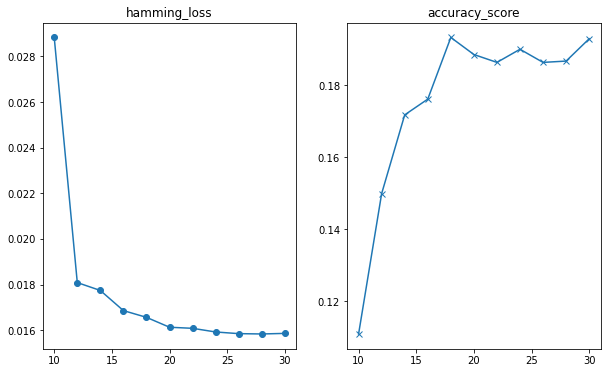

In [ ]:
fig=plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(range(10,31,2),ham_loss,marker='o')
ax1.title.set_text('hamming_loss')
ax2.plot(range(10,31,2),acc_score,marker='x')
ax2.title.set_text('accuracy_score')
plt.show()

In [119]:
mlknn_classifier = MLkNN(k=18)
mlknn_classifier.fit(X_train_tfidf, y_train)

MLkNN(ignore_first_neighbours=0, k=18, s=1.0)

In [ ]:
pred_best= mlknn_classifier.predict(X_test_tfidf)
  
print(accuracy_score(y_test, pred_best))
print(hamming_loss(y_test, pred_best))

0.19321910317170982
0.016562158220925993


## **Final Model** 

We have picked three model to be our contestors for the best final method. We have until now: 

- **BinaryRelevane** with the **RandomForest** classifier as estimator

- **Multi-kNN** classifier with k=18 Neighbors

- **OneVsRestClassifier** with the **XGBoost** classifier as an estimator

In [127]:
def missing_predictions(model,dt_eval):

  prediction_dict={'title':[],
                   'true_tags':[],
                   'predicted_tags':[]}
  for title in dt_eval:
    title_vect=vectorizar.transform([title])
    pred_title=model.predict(title_vect)
    pred_indexs=np.argsort(-pred_title)[:,:np.sum(pred_title)][0]
    tags_list=data_labels.iloc[:,5:].columns[pred_indexs].values.tolist()

    prediction_dict['title'].append(title)
    prediction_dict['true_tags'].append(data_labels.loc[data_labels['Title']==title,'main_tags'].values[0])
    prediction_dict['predicted_tags'].append(' '.join(word for word in tags_list))

  pred_df=pd.DataFrame(prediction_dict)
  pred_df.loc[pred_df['predicted_tags']=='','predicted_tags']=np.nan

  return pred_df.isna().sum()


In [122]:
missing_predictions(binary_clf_rand,X_test[:2000])

title               0
true_tags           0
predicted_tags    862
dtype: int64

In [123]:
missing_predictions(mlknn_classifier,X_test[:2000])

title               0
true_tags           0
predicted_tags    607
dtype: int64

In [128]:
missing_predictions(boost_best,X_test[:2000])

title               0
true_tags           0
predicted_tags    874
dtype: int64

One way to get the best out of these three methods, is to compare the rate of missing prediction. 

In this case, we can see that **Multi-kNN** gives the lowest rate

Thats it! we chose the **Multi-kNN** as our final model

### Test on unseen document

In [133]:
test_doc='i want to use pandas to filter reviews with the attributed score do i need to build a function with python '

In [147]:
def get_prediction(model,text):

  text_vect=vectorizar.transform([text])
  pred=model.predict(text_vect).toarray()
  pred_indexs=np.argsort(-pred)[:,:np.sum(pred)][0]
  tags_list=data_labels.iloc[:,5:].columns[pred_indexs].values.tolist()

  return tags_list

In [137]:
get_prediction(mlknn_classifier,test_doc)

['python']

In [138]:
test_doc2='how would firebase be connected to a flask app'

In [148]:
get_prediction(mlknn_classifier,test_doc2)

['firebase', 'flutter']

In [140]:
test_doc3='how local transitivity and barrat transitivity are calculated for directed graph in igraph rlang'

In [141]:
get_prediction(mlknn_classifier,test_doc3)

[]

In [149]:
test_doc4='faster way to query pandas dataframe for a value based on values in other column'

In [150]:
get_prediction(mlknn_classifier,test_doc4)

['python', 'dataframe', 'pandas']

In [151]:
test_doc5='how to create json file based on pandas dataframe python'
get_prediction(mlknn_classifier,test_doc5)

['python', 'json', 'pandas']

In [152]:
test_doc6='returning a value from within a nested javascript function duplicate'
get_prediction(mlknn_classifier,test_doc6)

['arrays', 'javascript']

In [153]:
test_doc7=  
get_prediction(mlknn_classifier,test_doc7)

['django']